# Xây dựng mô hình dự đoán sự biến động giá cổ phiếu MSN

---



Ý tưởng: Giá đóng cửa của phiên tiếp theo sẽ được dự đoán dựa trên tập hợp giá đóng cửa của rất nhiều phiên trước đó thông qua mạng noron hồi quy LSTM. Sau khi dự đoán được giá sẽ tính toán để dự đoán sự biến động về giá.

In [1]:
# khai báo các thư viện
import pandas as pd
import numpy as np
from keras.models import Sequential,load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Biểu diễn và chuẩn bị dữ liệu cho mô hình

In [3]:
data_msn = '/content/gdrive/MyDrive/FinPros/MSN.csv'
msn_df = pd.read_csv(data_msn) # đọc dữ liệu dạng dataframe
msn_df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,MSN,12/25/2017 9:15,73.1,73.1,73.1,73.1,4210,0
1,MSN,12/25/2017 9:16,73.0,73.0,73.0,73.0,5000,0
2,MSN,12/25/2017 9:18,73.5,73.5,73.5,73.5,210,0
3,MSN,12/25/2017 9:20,73.2,73.5,73.1,73.1,2050,0
4,MSN,12/25/2017 9:21,73.0,73.0,73.0,73.0,1380,0
...,...,...,...,...,...,...,...,...
135349,MSN,12/22/2020 14:23,82.8,82.8,82.8,82.8,700,0
135350,MSN,12/22/2020 14:24,82.7,82.8,82.7,82.8,4660,0
135351,MSN,12/22/2020 14:25,82.8,82.8,82.8,82.8,50,0
135352,MSN,12/22/2020 14:27,82.8,82.8,82.8,82.8,300,0


Do trong mô hình này chỉ dựa trên giá đóng cửa các phiên trước để dự đoán giá đóng cửa cho phiên tiếp theo nên loại bỏ các cột không cần thiết khỏi bảng dữ liệu dữ lại cột 'Close'

In [4]:
msn_df['Date/Time'] = pd.to_datetime(msn_df['Date/Time'])
msn_df['Date'] = msn_df['Date/Time'].dt.strftime('%d/%m/%Y')
msn_df = pd.DataFrame(msn_df,columns=['Date','Close'])
msn_df.drop(['Date'],axis=1,inplace=True)
msn_df

,Close
0,73.1
1,73.0
2,73.5
3,73.1
4,73.0
...,...
135349,82.8
135350,82.8
135351,82.8
135352,82.8


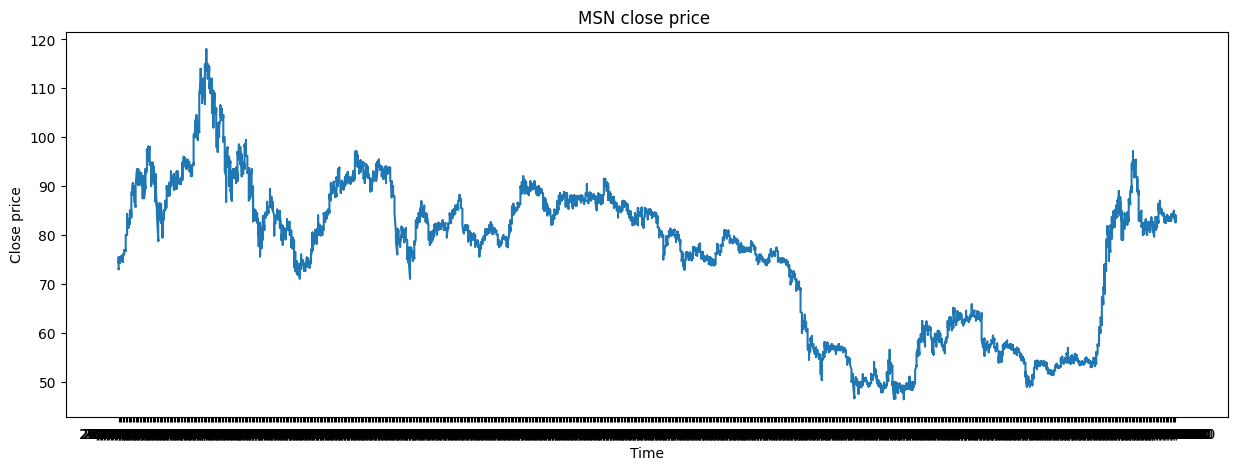

In [5]:
# vẽ đường biểu diễn giá đóng cửa
plt.figure(figsize=(15,5))
plt.plot(msn_df['Close'])
plt.title('MSN close price ')
plt.xlabel('Time')
plt.ylabel('Close price')
plt.show()

chia dữ liệu thành tập train và test

In [6]:
# tập dữ liệu gồm 135354 phiên nên sẽ lấy 125354 phiên để train còn lại để test
data = msn_df.values
test_size = 10000
data_train = data[:-1*test_size]
data_test = data[-1*test_size:]

# chuẩn hóa dữ liệu đầu vào về trong khoảng [0,1] để thuận tiện cho model tính toán nhẹ nhành hơn khi train
sc = MinMaxScaler(feature_range = (0, 1))
data_train_scaled = sc.fit_transform(data_train)

Do các phiên rất gần nhau khoảng vài phút nên sẽ lấy giá đóng cửa 1000 phiên dự đoán giá đóng cửa phiên tiếp theo

In [7]:
X_train = []
y_train = []
for i in range(1000, len(data_train)):
    X_train.append(data_train_scaled[i-1000:i,0])
    y_train.append(data_train_scaled[i, 0])

In [8]:
X_train = np.array(X_train).reshape(124354,1000,1)
y_train = np.array(y_train)
print(X_train.shape,y_train.shape)

(124354, 1000, 1) (124354,)


# Xây dựng Model

Mô hình được xây dựng là mô hình mạng noron hồi quy tuyến tính LSTM đơn giản

In [9]:
model = Sequential()
model.add(LSTM(units=128, input_shape=X_train.shape[1:],return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(loss='mean_absolute_error',optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 128)         66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116033 (453.25 KB)
Trainable params: 116033 (453.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


tạo file lưu và train model khoảng 50 epochs

In [13]:
save_model = 'Model_MSN.h5'# lưu model
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
history = model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2, callbacks=[best_model])

Epoch 1/50

Epoch 1: loss improved from inf to 0.01642, saving model to Stock_price_predict.h5
1944/1944 - 116s - loss: 0.0164 - 116s/epoch - 60ms/step
Epoch 2/50

Epoch 2: loss improved from 0.01642 to 0.01626, saving model to Stock_price_predict.h5
1944/1944 - 117s - loss: 0.0163 - 117s/epoch - 60ms/step
Epoch 3/50

Epoch 3: loss did not improve from 0.01626
1944/1944 - 117s - loss: 0.0163 - 117s/epoch - 60ms/step
Epoch 4/50

Epoch 4: loss improved from 0.01626 to 0.01620, saving model to Stock_price_predict.h5
1944/1944 - 116s - loss: 0.0162 - 116s/epoch - 60ms/step
Epoch 5/50

Epoch 5: loss improved from 0.01620 to 0.01615, saving model to Stock_price_predict.h5
1944/1944 - 116s - loss: 0.0161 - 116s/epoch - 60ms/step
Epoch 6/50

Epoch 6: loss did not improve from 0.01615
1944/1944 - 117s - loss: 0.0162 - 117s/epoch - 60ms/step
Epoch 7/50

Epoch 7: loss improved from 0.01615 to 0.01604, saving model to Stock_price_predict.h5
1944/1944 - 116s - loss: 0.0160 - 116s/epoch - 60ms/step


# Thử nghiệm và đánh giá Model

282/282 [==============================] - 200s 707ms/step


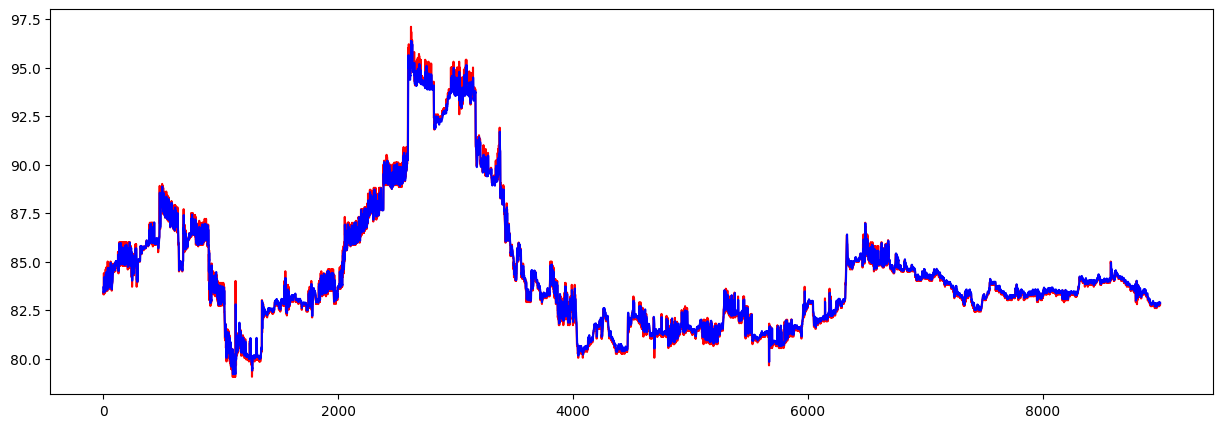

In [11]:
Model = load_model('Model_MSN.h5')
data_test_scaled = sc.fit_transform(data_test)
X_test = []
y_test = []
for i in range(1000, len(data_test_scaled)):
    X_test.append(data_test_scaled[i-1000:i,0])
    y_test.append(data_test[i,0])
X_test = np.array(X_test)
y_test_predict = Model.predict(X_test)
y_test_predict = sc.inverse_transform(y_test_predict)
plt.figure(figsize=(15,5))
plt.plot(y_test,color='red')
plt.plot(y_test_predict,color='blue')
plt.show()


Từ đồ thị bên trên có thể thấy giá dự đoán (đương màu xanh) và giá thực thế (đường màu đỏ) rất sát nhau điều đó chứng tỏ mô hình hoạt động tốt

Tiếp theo sẽ tính toán giá trị biến động của giá trên thực thế

In [36]:
msn_df['Pre_close'] = msn_df.loc[:,['Close']].shift(1)
# Thêm cột giá biến động trên thực tế 'Fluct'
msn_df['Fluct'] = msn_df['Close']-msn_df['Pre_close']
# Thêm cột 'Target' có giá trị '1' nếu giá cổ phiếu tăng và '0' nếu giá không tăng hoặc giảm
msn_df['Target'] = (msn_df['Fluct']>0).astype(int)
msn_df = msn_df.replace(np.inf,np.nan).dropna()
msn_df

,Close,Pre_close,Fluct,Target
1,73.0,73.1,-0.1,0
2,73.5,73.0,0.5,1
3,73.1,73.5,-0.4,0
4,73.0,73.1,-0.1,0
5,73.1,73.0,0.1,1
...,...,...,...,...
135349,82.8,82.8,0.0,0
135350,82.8,82.8,0.0,0
135351,82.8,82.8,0.0,0
135352,82.8,82.8,0.0,0


Tính toán và so sánh giá trị biến động dự đoán và thực thế

In [56]:
df = pd.DataFrame()
pre = msn_df['Pre_close']
ref = msn_df['Fluct']
target = msn_df['Target']
df['Fluct'] = ref[-9000:]
df['Predict_fluct']=y_test_predict.reshape(9000,).tolist()-pre[-9000:]
df['Target'] = target[-9000:]
df['Predict_target'] = (df['Predict_fluct'] > 0).astype(int)
df

,Fluct,Predict_fluct,Target,Predict_target
126354,0.00,0.266168,0,1
126355,-0.09,0.113916,0,1
126356,0.09,0.093862,1,1
126357,0.00,0.042680,0,1
126358,0.00,0.054750,0,1
...,...,...,...,...
135349,0.00,0.068011,0,1
135350,0.00,0.071155,0,1
135351,0.00,0.071674,0,1
135352,0.00,0.071582,0,1


vẽ biểu đồ confusion_matrix cho giá trị 'Target' dự đoán và thực thế

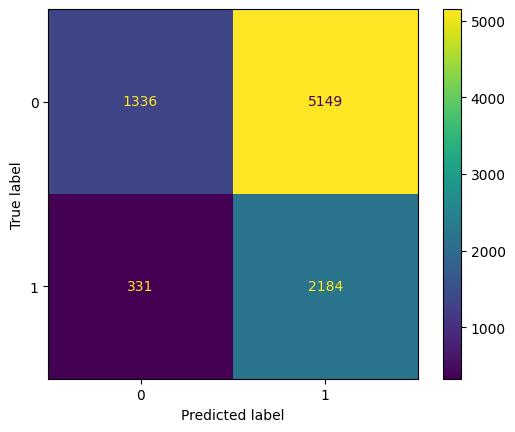

In [57]:
Target = df['Target'].tolist()
Predict_target = df['Predict_target'].tolist()
conf_matrix = confusion_matrix(Target,Predict_target)
disp = ConfusionMatrixDisplay( confusion_matrix=conf_matrix)
disp.plot()
plt.show()

In [58]:
# tính độ chính xác của mô hình
accuracy = accuracy_score(Target, Predict_target)
print('Accuracy: %f' % accuracy)

Accuracy: 0.391111


**Nhận xét:** từ bảng và biểu đồ trên cho thấy mô hình dự giá cổ phiếu rất sát với thực tế nhưng biến động giá cổ phiếu lại có sự sai lệch rất nhiều. Điều này là do các phiên tính theo phút và sự biến động giá cổ phiếu giữa các phiên giao dịch là rất nhỏ. Vì vậy nếu dự đoán sự biến động giá theo ngày thì có thể độ chính xác sẽ cao hơn.

In [12]:
msn_df1 = pd.read_csv(data_msn)
msn_df1 = pd.DataFrame(msn_df1,columns=['Date/Time','Close'])
msn_df1['Date/Time'] = pd.to_datetime(msn_df1['Date/Time'])
# Lấy giá trị của ngày/tháng/năm
msn_df1['Date'] = msn_df1['Date/Time'].dt.strftime('%d/%m/%Y')
# Lấy giá trị của giờ/phút
msn_df1['Time'] = msn_df1['Date/Time'].dt.strftime('%H:%M')
msn_df1['Pre_close']=msn_df1.loc[:,['Close']].shift(1)
msn_df1 = msn_df1.replace(np.inf,np.nan).dropna()
msn_df1['Fluct'] = (msn_df1['Close']-msn_df1['Pre_close'])
msn_df1['Target'] = (msn_df1['Fluct']>0).astype(int)
msn_df1

,Date/Time,Close,Date,Time,Pre_close,Fluct,Target
1,2017-12-25 09:16:00,73.0,25/12/2017,09:16,73.1,-0.1,0
2,2017-12-25 09:18:00,73.5,25/12/2017,09:18,73.0,0.5,1
3,2017-12-25 09:20:00,73.1,25/12/2017,09:20,73.5,-0.4,0
4,2017-12-25 09:21:00,73.0,25/12/2017,09:21,73.1,-0.1,0
5,2017-12-25 09:22:00,73.1,25/12/2017,09:22,73.0,0.1,1
...,...,...,...,...,...,...,...
135349,2020-12-22 14:23:00,82.8,22/12/2020,14:23,82.8,0.0,0
135350,2020-12-22 14:24:00,82.8,22/12/2020,14:24,82.8,0.0,0
135351,2020-12-22 14:25:00,82.8,22/12/2020,14:25,82.8,0.0,0
135352,2020-12-22 14:27:00,82.8,22/12/2020,14:27,82.8,0.0,0


Tạo bảng dữ liệu tương ứng với dữ liệu trong tập test sau đó lấy giá đóng cửa của phiên cuối cũng của mỗi ngày.

In [13]:
msn_df1 = msn_df1.tail(9000)
msn_df1 = msn_df1.reset_index()
msn_df1 = msn_df1.groupby('Date').tail(1)
msn_df1

,index,Date/Time,Close,Date,Time,Pre_close,Fluct,Target
62,126416,2020-10-22 14:46:00,85.00,22/10/2020,14:46,84.60,0.40,1
283,126637,2020-10-23 14:46:00,84.99,23/10/2020,14:46,84.99,0.00,0
478,126832,2020-10-26 14:46:00,86.86,26/10/2020,14:46,86.27,0.59,1
680,127034,2020-10-27 14:46:00,86.86,27/10/2020,14:46,84.99,1.87,1
902,127256,2020-10-28 14:46:00,84.99,28/10/2020,14:46,85.58,-0.59,0
1126,127480,2020-10-29 14:46:00,84.00,29/10/2020,14:46,79.25,4.75,1
1350,127704,2020-10-30 14:46:00,83.01,30/10/2020,14:46,80.44,2.57,1
1550,127904,2020-11-02 14:46:00,84.50,02/11/2020,14:46,83.01,1.49,1
1771,128125,2020-11-03 14:46:00,84.00,03/11/2020,14:46,83.21,0.79,1
1973,128327,2020-11-04 14:46:00,83.21,04/11/2020,14:46,83.60,-0.39,0


Tạo 2 danh sánh các giá trị giá đóng cửa thực thế và giá dự đoán của mỗi ngày sau đó vẽ biểu đồ 2 đường giá.

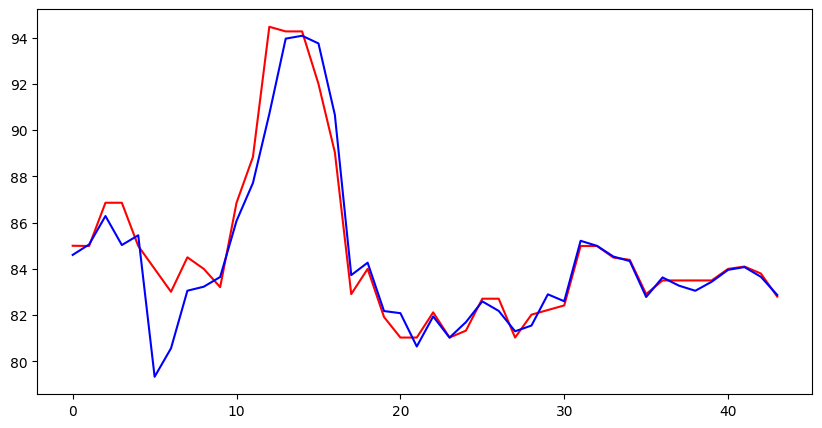

In [14]:
list1 = msn_df1.index.values
list1.tolist()
predict_price = []
true_price = []
for i in list1:
  predict_price.append(y_test_predict[i])
  true_price.append(msn_df1['Close'][i])
plt.figure(figsize=(10,5))
plt.plot(true_price,color='red')
plt.plot(predict_price,color='blue')
plt.show()


tính toán biến động giá cổ phiếu mỗi ngày trong thực tế

In [15]:
msn_df1['Pre_close'] = msn_df1.loc[:,['Close']].shift(1)
msn_df1['Fluct'] = msn_df1['Close']-msn_df1['Pre_close']
msn_df1['Target'] = (msn_df1['Fluct']>0).astype(int)
msn_df1 = msn_df1.replace(np.inf,np.nan).dropna()
msn_df1

,index,Date/Time,Close,Date,Time,Pre_close,Fluct,Target
283,126637,2020-10-23 14:46:00,84.99,23/10/2020,14:46,85.00,-0.01,0
478,126832,2020-10-26 14:46:00,86.86,26/10/2020,14:46,84.99,1.87,1
680,127034,2020-10-27 14:46:00,86.86,27/10/2020,14:46,86.86,0.00,0
902,127256,2020-10-28 14:46:00,84.99,28/10/2020,14:46,86.86,-1.87,0
1126,127480,2020-10-29 14:46:00,84.00,29/10/2020,14:46,84.99,-0.99,0
1350,127704,2020-10-30 14:46:00,83.01,30/10/2020,14:46,84.00,-0.99,0
1550,127904,2020-11-02 14:46:00,84.50,02/11/2020,14:46,83.01,1.49,1
1771,128125,2020-11-03 14:46:00,84.00,03/11/2020,14:46,84.50,-0.50,0
1973,128327,2020-11-04 14:46:00,83.21,04/11/2020,14:46,84.00,-0.79,0
2187,128541,2020-11-05 14:46:00,86.86,05/11/2020,14:46,83.21,3.65,1


Tính toán biến động giá cổ phiếu được mô hình dự đoán và so sáng với thực tế

In [16]:
df2 = pd.DataFrame()
pre1 = msn_df1['Pre_close']
ref1 = msn_df1['Fluct']
target1 = msn_df1['Target']
predict_price = np.array(predict_price)
df2['Predict_fluct']=predict_price[1:].reshape(43,).tolist()-pre1
df2['Fluct'] = ref1
df2['Target'] = target1
df2['Predict_target'] = (df2['Predict_fluct'] > 0).astype(int)
df2.head(10)

,Predict_fluct,Fluct,Target,Predict_target
283,0.054214,-0.01,0,1
478,1.295690,1.87,1,1
680,-1.828834,0.00,0,0
902,-1.407615,-1.87,0,0
1126,-5.656122,-0.99,0,0
1350,-3.433357,-0.99,0,0
1550,0.045664,1.49,1,1
1771,-1.270630,-0.50,0,0
1973,-0.350410,-0.79,0,0
2187,2.867911,3.65,1,1


Confusion_matrix của Target theo thực tế và được dự đoán

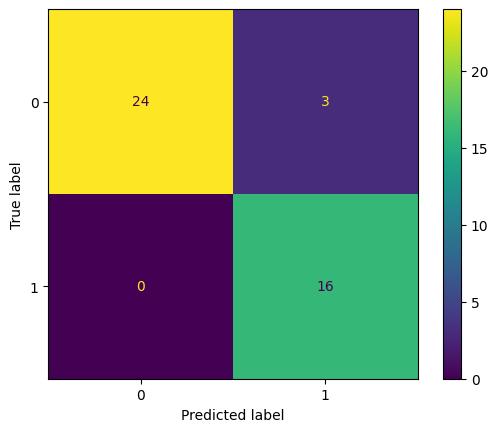

In [17]:
Target1 = df2['Target'].tolist()
Predict_target1 = df2['Predict_target'].tolist()
conf_matrix1 = confusion_matrix(Target1,Predict_target1)
disp1 = ConfusionMatrixDisplay( confusion_matrix=conf_matrix1)
disp1.plot()
plt.show()

In [18]:
accuracy1 = accuracy_score(Target1, Predict_target1)
print('Accuracy: %f' % accuracy1)

Accuracy: 0.930233


**Nhận xét:** Từ biểu đồ trên cho thấy mô hình dự đoán sự biến động về giá cổ phiếu theo ngày chính xác đạt đến 93%





# Kết Luận
Với phương pháp tiếp cận theo mô hình học sâu dùng mạng noron nhân tạo ta có thể xây dựng được mô hình dự đoán biến động giá cổ phiếu khá đáng tin cậy với việc dự đoán biến động giá cổ phiếu theo ngày.